In [1]:
import cv2
import argparse
import json
import numpy as np
from tqdm import tqdm
from os.path import exists
import os

from segment_anything import sam_model_registry
from automatic_mask_generator import SamAutomaticMaskGenerator
import matplotlib.pyplot as plt

In [2]:
def show_anns(anns,color):
    if len(anns) == 0:
        return
    sorted_anns = sorted(anns, key=(lambda x: x['area']), reverse=True)
    ax = plt.gca()
    ax.set_autoscale_on(False)
    for ann in sorted_anns:
        x0, y0, w, h = ann['bbox']
        ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor=color, facecolor=(0,0,0,0), lw=2))
        ax.scatter([x0+w//2], [y0+h//2], color=color, marker='*', s=10, edgecolor='white', linewidth=1.25)

In [3]:
data_path = 'data/coco2017/'
anno_file = data_path + 'annotations_trainval2017/annotations/instances_val2017.json'
im_dir = data_path + 'val2017'
model_type = 'vit_h'
model_path = 'data/pretrainedModels/sam_vit_h_4b8939.pth'

if not exists(anno_file) or not exists(im_dir):
    print("Make sure you set up the --data-path correctly.")
    print("Current setting is {}, but the image dir and annotation file do not exist.".format(data_path))
    print("Aborting the evaluation")
    assert False

In [4]:
# change this if you want to run on other gpus
device = 'cuda'
sam = sam_model_registry[model_type](checkpoint=model_path)
sam.to(device=device)

mask_generator = SamAutomaticMaskGenerator(
                                model=sam,
                                min_mask_region_area=25
                                )

In [5]:
with open(anno_file) as f:
    annotations = json.load(f)
images = sorted(annotations['images'],key=lambda x:x['file_name'])
# print(images[0])
prepared_json = {}
for i in images:
    prepared_json[i['file_name']] = {
        "H":i['height'],
        "W":i['width'],
        "boxes":{},
        # "category_ids":[],
    }
for i in annotations['annotations']:
    im_id = str(i['image_id'])
    prezero = 12 - len(im_id)
    im_id = '0'*prezero + im_id + ".jpg"
    if i["category_id"] in prepared_json[im_id]["boxes"]:
        prepared_json[im_id]["boxes"][i["category_id"]].append(i['bbox'])
    else:
        prepared_json[im_id]["boxes"][i["category_id"]] = []
        prepared_json[im_id]["boxes"][i["category_id"]].append(i['bbox'])

In [6]:
folds = [
    [1,5,9,14,18,22,27,33,37,41,46,50,54,58,62,67,74,78,82,87],
    [2,6,10,15,19,23,28,34,38,42,47,51,55,59,63,70,75,79,84,88],
    [3,7,11,16,20,24,31,35,39,43,48,52,56,60,64,72,76,80,85,89],
    [4,8,13,17,21,25,32,36,40,44,49,53,57,61,65,73,77,81,86,90],
]

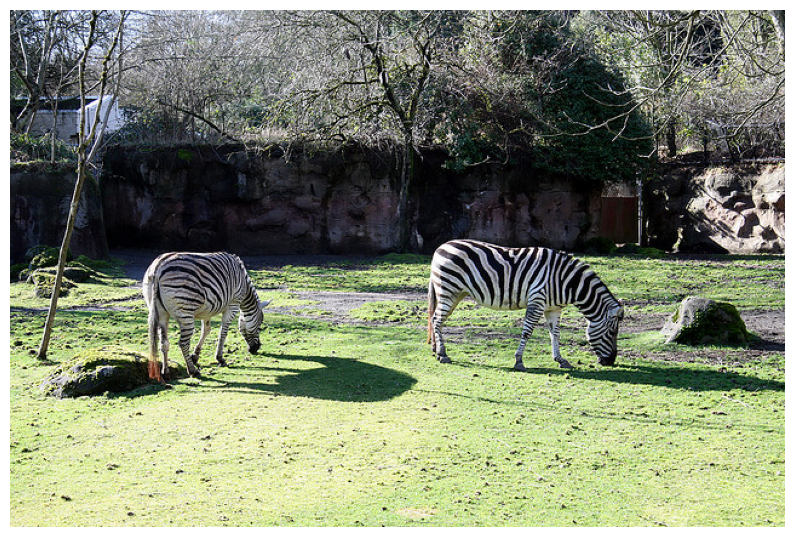

In [7]:
# change this if you want to vis other image
im_id = '000000020059.jpg'
image = cv2.imread('{}/{}'.format(im_dir, im_id))
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(10,10))
plt.imshow(image)
plt.axis('off')
plt.show()
plt.close()

In [8]:
# change this if you want to change color of the boxes
colors = [
    'green','blue','darkorange','red','purple','cyan','lawngreen','dimgrey'
]

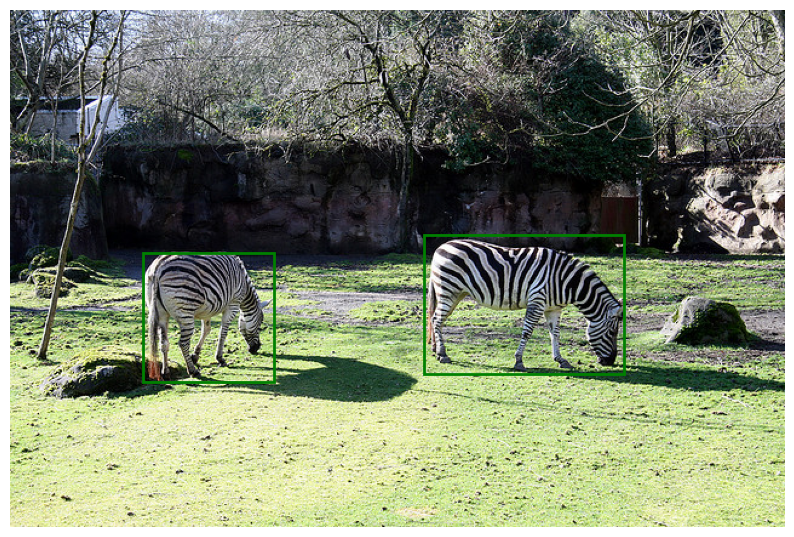

In [9]:
# show gt boxes
plt.figure(figsize=(10,10))
plt.imshow(image)
ax = plt.gca()
cnt = 0
for i in prepared_json[im_id]["boxes"]:
    for j in prepared_json[im_id]["boxes"][i]:
        ax.add_patch(plt.Rectangle((j[0], j[1]),j[2],j[3],edgecolor=colors[cnt%len(colors)], facecolor=(0,0,0,0), lw=2))
    cnt += 1
plt.axis('off')
plt.show()
plt.close()

In [10]:
# process
category_id = list(prepared_json[im_id]['boxes'].keys())
pre_masks = []
for id in category_id:
    boxes = prepared_json[im_id]['boxes'][id]
    
    input_boxes = list()
    x1, y1 = boxes[0][0],boxes[0][1]
    x2, y2 = boxes[0][0] + boxes[0][2],boxes[0][1] + boxes[0][3]
    input_boxes.append([x1, y1, x2, y2])
    
    masks = mask_generator.generate(image, input_boxes)
    
    pre_masks.append(masks)

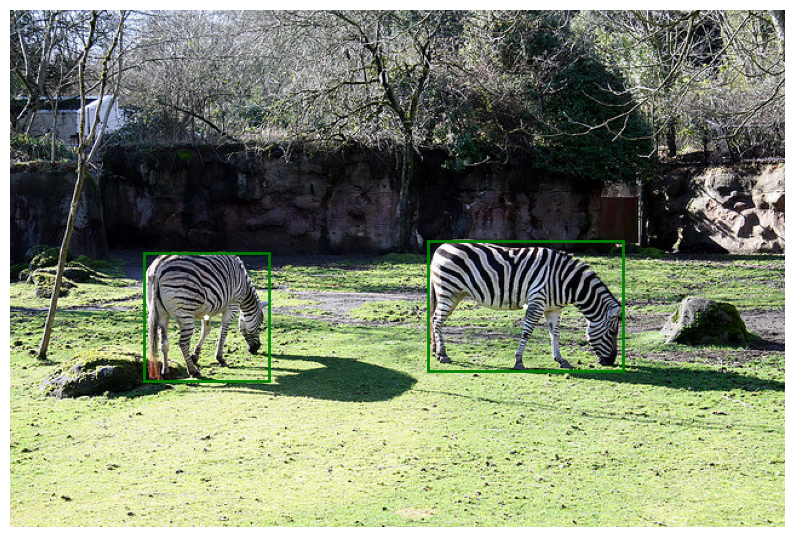

In [11]:
# show predicted boxes
plt.figure(figsize=(10,10))
plt.imshow(image)
ax = plt.gca()
cnt = 0
for i in pre_masks:
    show_anns(i,colors[cnt%len(colors)])
    cnt += 1
plt.axis('off')
plt.show()
plt.close()